In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import celestializer as cl
import numpy as np
from tqdm import tqdm
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from sklearn.cluster import KMeans

In [3]:

img_sky = cl.RawImage(cl.Paths.observations / "2024-11-05/IMG_3320.CR2").load()
img = img_sky.raw().green_interpolated()
img_sky.metadata.model_dump()

{'width': 5202,
 'height': 3465,
 'focal_length': 18.0,
 'aperture': 3.5,
 'shutter': 10.0,
 'iso': 6400,
 'timestamp': datetime.datetime(2024, 11, 5, 0, 37, 58),
 'camera': 'Canon EOS 1200D',
 'bit_depth': 14}

In [4]:
img_in = img.green_interpolated()
img_in = cl.correct_vignette(img_in)
img_in = img_in.channel("green")

mask_hot, mask_dead = cl.find_defects(img_in)
print(f"Found {mask_hot.sum()} hot pixels and {mask_dead.sum()} dead pixels")
mask = mask_hot | mask_dead
img_in = cl.replace_defects(img_in, mask)
img_in = img_in.green_interpolated()
img_in -= img_in.min()
img_in /= img_in.max()

Found 42 hot pixels and 107 dead pixels


In [5]:
mask = cl.classify_star_pixels(img_in.to_bitdepth(8))
stars = cl.stars_from_mask(mask)
print(f"Found {len(stars)} stars")

100%|██████████| 914/914 [00:06<00:00, 133.88it/s]


Found 914 stars


In [193]:
def show_star_pixels(img: cl.ImageNBit, star: cl.StarPixels) -> cl.ImageNBit:
    star_pixels = img[
        star.bbox[1] : star.bbox[1] + star.bbox[3],
        star.bbox[0] : star.bbox[0] + star.bbox[2],
    ].copy()
    # Convert image to 3 channels
    star_color = np.zeros(
        (star_pixels.shape[0], star_pixels.shape[1], 3), dtype=img.dtype
    )
    for i in range(3):
        star_color[:, :, i] = star_pixels
    star_color[~star.mask, 1] = 0
    star_color[~star.mask, 2] = 0
    star_color[star.mask, 0] = 0
    star_color[star.mask, 2] = 0
    return cl.ImageNBit(star_color, img.bit_depth)


def refine_mask(img: cl.ImageNBit, star: cl.StarPixels) -> cl.StarPixels:
    # Must be 2D for padding
    assert img.ndim == 2, "Image must be 2D"
    # (top, bottom), (left, right)
    grow = ((2, 2), (2, 2))
    # Reduce grow if at the edge
    grow = (
        (
            min(grow[0][0], star.bbox[1]),
            min(grow[0][1], img.shape[0] - star.bbox[1] - star.bbox[3]),
        ),
        (
            min(grow[1][0], star.bbox[0]),
            min(grow[1][1], img.shape[1] - star.bbox[0] - star.bbox[2]),
        ),
    )

    # Dilate the mask
    kernel = np.asarray([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
    mask_padded = np.pad(star.mask.astype(np.uint8), grow, mode="constant")
    mask_dilated = cv2.dilate(mask_padded, kernel, iterations=2)
    mask_dilated = mask_dilated.astype(bool)

    # Apply the mask
    img_star = img[
        star.bbox[1] - grow[0][0] : star.bbox[1] + star.bbox[3] + grow[0][1],
        star.bbox[0] - grow[1][0] : star.bbox[0] + star.bbox[2] + grow[1][1],
    ].copy()

    # Get new mask by clustering
    kmeans = KMeans(n_clusters=2, random_state=0).fit(
        img_star[mask_dilated].reshape(-1, 1)
    )
    pred = kmeans.predict(img_star.reshape(-1, 1)).reshape(img_star.shape)
    right_cluster = np.argmax(kmeans.cluster_centers_)
    new_mask = pred == right_cluster

    # Find new bounding box
    new_bbox = cv2.boundingRect(new_mask.astype(np.uint8))
    # Cut the mask
    new_mask = new_mask[
        new_bbox[1] : new_bbox[1] + new_bbox[3],
        new_bbox[0] : new_bbox[0] + new_bbox[2],
    ]
    new_bbox = (
        star.bbox[0] - grow[1][0] + new_bbox[0],
        star.bbox[1] - grow[0][0] + new_bbox[1],
        new_bbox[2],
        new_bbox[3],
    )
    new_star = cl.StarPixels(x=star.x, y=star.y, mask=new_mask, bbox=new_bbox)
    return new_star


# stars_ordered = sorted(
#     stars,
#     key=lambda star: star.bbox[2] * star.bbox[3],
#     reverse=True,
# )
stars_ordered = stars
stars = []
for star in tqdm(stars_ordered):
    # star_pixels = show_star_pixels(img_in, star)
    # star_pixels.upscale(4).show()
    star_new = refine_mask(img_in, star)
    # star_pixels_new = show_star_pixels(img_in, star_new)
    # star_pixels_new.upscale(4).show()
    stars.append(star_new)

100%|██████████| 762/762 [00:00<00:00, 989.73it/s] 


Min magnitude: 0.5776379704475403
Max magnitude: 101.40133666992188


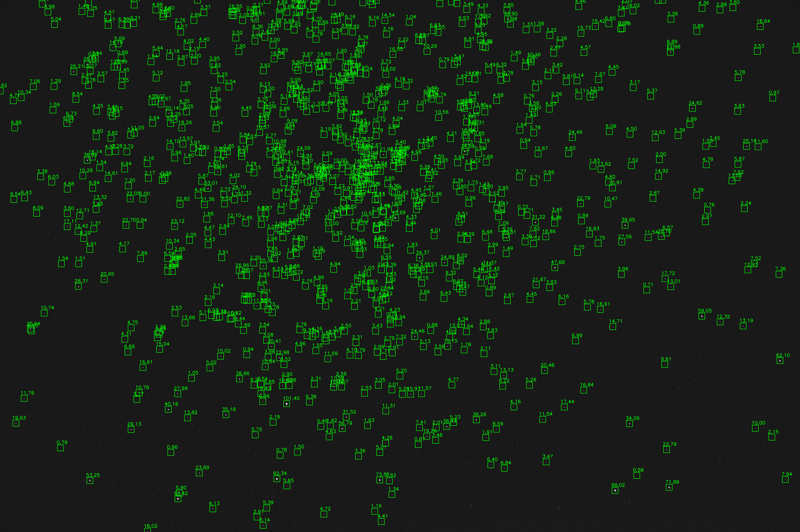

In [6]:
def predict_magnitude(img: cl.ImageNBit, star: cl.StarPixels) -> cl.StarMag:
    # Extract star pixels
    star_pixels = img[
        star.bbox[1] : star.bbox[1] + star.bbox[3],
        star.bbox[0] : star.bbox[0] + star.bbox[2],
    ]
    star_pixels = star_pixels[star.mask]
    magnitude = star_pixels.sum()
    return cl.StarMag(x=star.x, y=star.y, magnitude=magnitude)

img_pred = img_in.to_bitdepth(1)
predictions = [predict_magnitude(img_pred, star) for star in stars]
magnitudes = [p.magnitude for p in predictions]
print(f"Min magnitude: {min(magnitudes)}")
print(f"Max magnitude: {max(magnitudes)}")
# Show result
img_out = cl.show_stars(img_in, predictions)
img_out.preview().show()
img_out.save(cl.Paths.saved / "stars_pixel_sum.png")

In [7]:
stars_top = sorted(predictions, key=lambda p: p.magnitude, reverse=True)[:60]
match = cl.find_coordinates(stars_top, cl.CameraInfo())
print(f"Matched {len(match.stars)} stars")

Finding coordinates


ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (2 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (5 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-wcs.c, line 118)
ERROR:root:fit_sip_wcs: Too few correspondences for the SIP order specified (7 < 10) (astrometry.net/util/fit-w

Matched 107 stars


In [185]:
# https://simbad.cds.unistra.fr/simbad/tap/help/adqlHelp.html

wcs = match.astropy_wcs()
# Calculate radius of image
diag = np.sqrt(img.shape[0] ** 2 + img.shape[1] ** 2)
radius_img = diag / 2 * match.scale_arcsec_per_pixel / 3600 * u.deg * 1.01

print(f"Querying for radius {radius_img}")
print("Sending query to Simbad")
simbad = Simbad()
simbad.reset_votable_fields()
simbad.add_votable_fields("main_id", "ra", "dec", "otype", "V")
result = simbad.query_region(
    SkyCoord(
        ra=match.center_ra_deg, dec=match.center_dec_deg, unit=(u.deg, u.deg)
    ),
    radius=radius_img,
    criteria='"otype"=\'Star..\' and "V" < 8',
)
print(f"Found {len(result)} stars")

Querying for radius 28.172622905105403 deg
Sending query to Simbad


Found 4001 stars


In [186]:
result.pprint(max_lines=10, max_width=-1)

 main_id           ra                dec        coo_err_maj coo_err_min coo_err_angle coo_wavelength     coo_bibcode             V         otype
                  deg                deg            mas         mas          deg                                                                
---------- ------------------ ----------------- ----------- ----------- ------------- -------------- ------------------- ----------------- -----
 HD 200104  315.0564398325499    36.96307092213       0.009      0.0114            90              O 2020yCat.1350....0G 7.809999942779541   SB*
 HD 199496    314.09904832722     36.3773615058      0.0175      0.0219            90              O 2020yCat.1350....0G 7.829999923706055     *
       ...                ...               ...         ...         ...           ...            ...                 ...               ...   ...
HD 187343A  297.1429201510796   24.962182880295      0.0405      0.0689            90              O 2020yCat.1350....0G 7.5599999

In [195]:
stars_sub = stars
xys = np.array([[star.x, star.y] for star in stars_sub]).T
ras, decs = wcs.all_pix2world(xys[0], xys[1], 0)
# radii_px = np.array(
#     [max(star.bounding_box[2], star.bounding_box[3]) * 1.5 for star in stars_sub]
# )
# radii_deg = degree_per_pixel(wcs) * radii_px * u.deg
prompts = SkyCoord(ra=ras, dec=decs, unit=(u.deg, u.deg))
catalog = SkyCoord(ra=result["ra"], dec=result["dec"], unit=(u.deg, u.deg))
idx, d2d, d3d = prompts.match_to_catalog_sky(catalog)

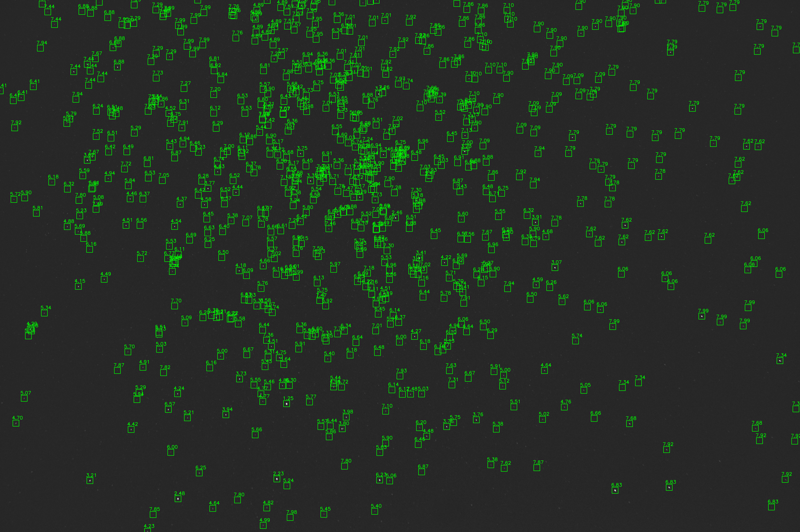

In [196]:
ground_truth = []
for i in range(len(idx)):
    star = stars_sub[i]
    star_catalog = result[idx[i]]
    ground_truth.append(cl.StarMag(
        x=star.x, y=star.y, magnitude=star_catalog["V"]
    ))

img_out = cl.show_stars(img_in, ground_truth)
img_out.preview().show()
img_out.save(cl.Paths.saved / "stars_by_flood_fill_ground_truth.png")

In [197]:
from scipy.optimize import curve_fit
def func(x, a, b, c, d):
    return a * np.exp(-b * (x - c)) + d

mags = np.asarray([star.magnitude for star in predictions])
true_mags = np.asarray([star.magnitude for star in ground_truth])
popt, pcov = curve_fit(func, mags, true_mags)
print(popt)

[1.75308721 0.08523926 7.59675669 4.39662604]


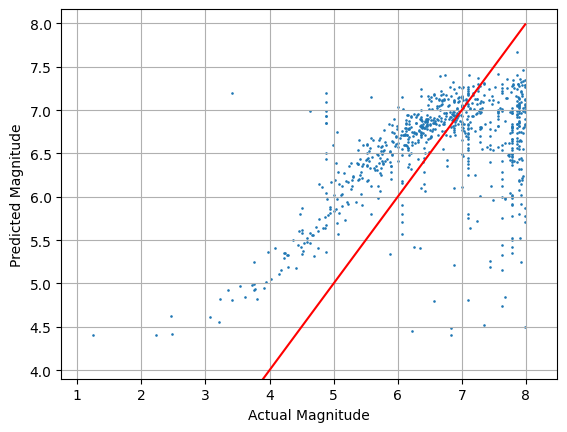

In [198]:
import matplotlib.pyplot as plt

pred_mags = np.asarray([star.magnitude for star in predictions])
pred_mags = func(pred_mags, *popt)
true_mags = np.asarray([star.magnitude for star in ground_truth])
xlim = [true_mags.min(), true_mags.max()]
ylim = [pred_mags.min(), pred_mags.max()]
line = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]

# Plot comparison
plt.figure()
plt.scatter(true_mags, pred_mags, marker=".", s=3)
plt.plot(line, line, color="red")
plt.xlim([xlim[0] - 0.5, xlim[1] + 0.5])
plt.ylim([ylim[0] - 0.5, ylim[1] + 0.5])
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude")
plt.grid()
plt.show()

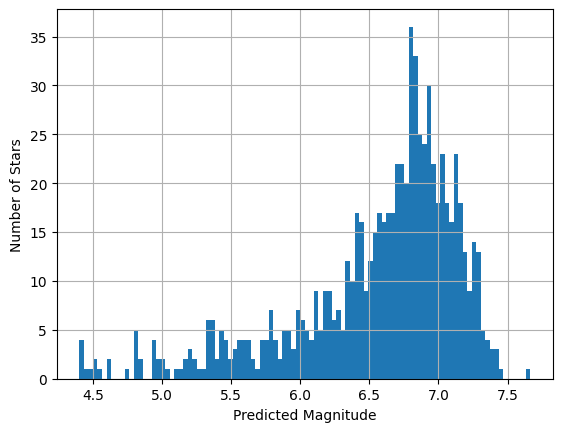

In [200]:
# Histogram predicted magnitudes
plt.figure()
plt.hist(pred_mags, bins=100)
plt.xlabel("Predicted Magnitude")
plt.ylabel("Number of Stars")
plt.xscale("log")
plt.yscale("log")
plt.grid()
plt.show()

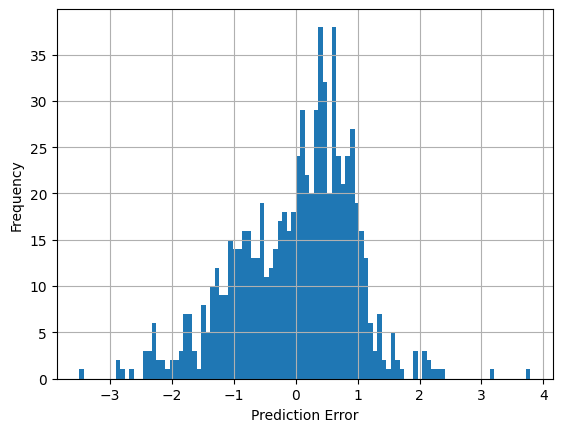

In [199]:
# Histogram prediction error
plt.figure()
plt.hist(pred_mags - true_mags, bins=100)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.yscale("log")
plt.grid()
plt.show()